# Data preparation

##Data Cleaning

In [ ]:
!git clone https://github.com/shionguha/inf2178-expdesignfordatascience-w23.git

Cloning into 'inf2178-expdesignfordatascience-w23'...
remote: Enumerating objects: 2850, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 2850 (delta 47), reused 64 (delta 28), pack-reused 2763
Receiving objects: 100% (2850/2850), 106.17 MiB | 9.04 MiB/s, done.
Resolving deltas: 100% (1107/1107), done.
Updating files: 100% (210/210), done.


In [ ]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 KB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=f4057c952728347f08504d75c1a35d7bed02cdb11232e80a2430731f7c642451
  Stored in directory: /root/.cache/pip/wheels/04/bb/0d/2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


In [ ]:
#import necessary Packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pingouin as pg
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.stats.multicomp as mc

from  IPython.display import display_html
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('Lets get started')

Lets get started


In [ ]:
df = pd.read_csv('/content/inf2178-expdesignfordatascience-w23/project dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv')
df.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age_group__at_arrest_,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Resisted__d,Actions_at_arrest___Mental_inst,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,1,NaN,NaN,NaN,NaN,NaN,1
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,2
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,3
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,5


In [ ]:
df = df.drop_duplicates(subset=['EventID','ArrestID','PersonID'], keep='last')

In [ ]:
#Deal with the Age_group__at_arrest_ missing value
#Fill other searchreason related columns and itemfound with 0
df = df.fillna(value = {
    'ArrestID': 9999999,
    'SearchReason_CauseInjury': 0,
    'SearchReason_AssistEscape': 0,
    'SearchReason_PossessWeapons': 0,
    'SearchReason_PossessEvidence':0,
    'ItemsFound': 0
    })

#Fill the missing value in Occurrence_Category with the value of the cell directly above it
df['Occurrence_Category'].fillna(method='ffill', inplace=True)

#There are only 24 values missing in this column under the total entries of 65276, let's drop them
#Drop the perceived race null value as well since there are only 4 missing values
df = df.dropna()

df.isnull().sum()

Arrest_Year                        0
Arrest_Month                       0
EventID                            0
ArrestID                           0
PersonID                           0
Perceived_Race                     0
Sex                                0
Age_group__at_arrest_              0
Youth_at_arrest__under_18_years    0
ArrestLocDiv                       0
StripSearch                        0
Booked                             0
Occurrence_Category                0
Actions_at_arrest___Concealed_i    0
Actions_at_arrest___Combative__    0
Actions_at_arrest___Resisted__d    0
Actions_at_arrest___Mental_inst    0
Actions_at_arrest___Assaulted_o    0
Actions_at_arrest___Cooperative    0
SearchReason_CauseInjury           0
SearchReason_AssistEscape          0
SearchReason_PossessWeapons        0
SearchReason_PossessEvidence       0
ItemsFound                         0
ObjectId                           0
dtype: int64

## Data Transformation 

### DF 1: ss - Logistic Regression Table

In [ ]:
#subset from the original dataset for the usage of logistic regression
#drop duplicate entries
ss = df.copy()

ss = ss[ss['Sex']!='U']
ss = ss.rename(columns={'Age_group__at_arrest_': 'Age'})

ss['Actions_at_arrest'] = ss['Actions_at_arrest___Concealed_i'] + ss['Actions_at_arrest___Combative__'] + ss['Actions_at_arrest___Mental_inst'] + ss['Actions_at_arrest___Concealed_i'] + ss['Actions_at_arrest___Assaulted_o'] + ss['Actions_at_arrest___Cooperative']

ss["Arrest_Quater"] = ss["Arrest_Month"].map({"Jan-Mar": 1, 
                                              "Apr-June": 2,
                                              "July-Sept": 3,
                                              "Oct-Dec": 4})

# ss = ss[['Arrest_Year',
#          'Arrest_Quater',
#          'Perceived_Race',
#          'Sex',
#          'Age',
#          'Actions_at_arrest',
#          'StripSearch']]

ss.head()

,Arrest_Year,Arrest_Month,EventID,ArrestID,PersonID,Perceived_Race,Sex,Age,Youth_at_arrest__under_18_years,ArrestLocDiv,...,Actions_at_arrest___Assaulted_o,Actions_at_arrest___Cooperative,SearchReason_CauseInjury,SearchReason_AssistEscape,SearchReason_PossessWeapons,SearchReason_PossessEvidence,ItemsFound,ObjectId,Actions_at_arrest,Arrest_Quater
0,2020,July-Sept,1005907,6017884.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,1,0.0,0.0,0.0,0.0,0.0,1,1,3
1,2020,July-Sept,1014562,6056669.0,326622,White,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0.0,0.0,0.0,0.0,0.0,2,0,3
2,2020,Oct-Dec,1029922,6057065.0,326622,Unknown or Legacy,M,Aged 35 to 44 years,Not a youth,54,...,0,0,0.0,0.0,0.0,0.0,0.0,3,0,4
3,2021,Jan-Mar,1052190,6029059.0,327535,Black,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0.0,0.0,0.0,0.0,0.0,4,0,1
4,2021,Jan-Mar,1015512,6040372.0,327535,South Asian,M,Aged 25 to 34 years,Not a youth,XX,...,0,0,0.0,0.0,0.0,0.0,0.0,5,0,1


In [ ]:
ss.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65235 entries, 0 to 65275
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Arrest_Year                      65235 non-null  int64  
 1   Arrest_Month                     65235 non-null  object 
 2   EventID                          65235 non-null  int64  
 3   ArrestID                         65235 non-null  float64
 4   PersonID                         65235 non-null  int64  
 5   Perceived_Race                   65235 non-null  object 
 6   Sex                              65235 non-null  object 
 7   Age                              65235 non-null  object 
 8   Youth_at_arrest__under_18_years  65235 non-null  object 
 9   ArrestLocDiv                     65235 non-null  object 
 10  StripSearch                      65235 non-null  int64  
 11  Booked                           65235 non-null  int64  
 12  Occurrence_Categor

### DF 2: ssif - Ancova Table

In [ ]:
ssif = df.groupby([
    'Arrest_Year',
    'Arrest_Month',
    'Perceived_Race',
    'Sex'])['StripSearch','ItemsFound'].sum().reset_index()

ssif = ssif[ssif['Sex']!='U']
ssif.head()

,Arrest_Year,Arrest_Month,Perceived_Race,Sex,StripSearch,ItemsFound
0,2020,Apr-June,Black,F,46,24.0
1,2020,Apr-June,Black,M,480,195.0
2,2020,Apr-June,East/Southeast Asian,F,6,1.0
3,2020,Apr-June,East/Southeast Asian,M,75,28.0
4,2020,Apr-June,Indigenous,F,13,7.0


In [ ]:
ssif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128 entries, 0 to 133
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Arrest_Year     128 non-null    int64  
 1   Arrest_Month    128 non-null    object 
 2   Perceived_Race  128 non-null    object 
 3   Sex             128 non-null    object 
 4   StripSearch     128 non-null    int64  
 5   ItemsFound      128 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 7.0+ KB


# EDA

## Logistic Regression DF EDA

### Pivot Tables

In [ ]:
palette = sns.light_palette('#C0DBEA',as_cmap='true')

In [ ]:
def plot_pivot (values_input, index_input): 
  
  names = {
      "mean": "MeanStripSearchRate",
      "sum": "StripSearchers",
      "count": "GroupSize",
  }

  pivot1 = (
      ss.pivot_table(
          values = values_input,
          index = index_input,
          aggfunc = ['mean', 'sum', 'count'],
          margins = True,
          margins_name = 'Total',
      )
      .rename(
          columns = names,
      )
      .droplevel(level=1, axis='columns')
      .style.background_gradient(palette)
      .set_table_attributes("style='display:inline'")
  )

  display_html(pivot1._repr_html_(), raw=True)

In [ ]:
plot_pivot ('StripSearch', 'Perceived_Race')

,MeanStripSearchRate,StripSearchers,GroupSize
Perceived_Race,,,
Black,0.138902,2433,17516
East/Southeast Asian,0.077289,341,4412
Indigenous,0.158385,306,1932
Latino,0.074703,132,1767
Middle-Eastern,0.070436,228,3237
South Asian,0.071132,257,3613
Unknown or Legacy,0.106097,536,5052
White,0.128672,3565,27706
Total,0.119537,7798,65235


In [ ]:
plot_pivot ('StripSearch', 'Sex')

,MeanStripSearchRate,StripSearchers,GroupSize
Sex,,,
F,0.101769,1283,12607
M,0.123793,6515,52628
Total,0.119537,7798,65235


In [ ]:
plot_pivot ('StripSearch', 'Age')

,MeanStripSearchRate,StripSearchers,GroupSize
Age,,,
Aged 17 years and under,0.006613,9,1361
Aged 17 years and younger,0.161214,271,1681
Aged 18 to 24 years,0.134389,1349,10038
Aged 25 to 34 years,0.132270,2770,20942
Aged 35 to 44 years,0.129080,2096,16238
Aged 45 to 54 years,0.099835,905,9065
Aged 55 to 64 years,0.078901,362,4588
Aged 65 and older,0.049679,31,624
Aged 65 years and older,0.007163,5,698


In [ ]:
plot_pivot ('StripSearch', 'Actions_at_arrest')

,MeanStripSearchRate,StripSearchers,GroupSize
Actions_at_arrest,,,
0,0.111070,3566,32106
1,0.117172,3682,31424
2,0.309686,454,1466
3,0.413146,88,213
4,0.307692,8,26
Total,0.119537,7798,65235


In [ ]:
plot_pivot('StripSearch', ('Sex','Actions_at_arrest'))

MeanStripSearchRate 
 StripSearchers 
 GroupSize 
 
 
 Sex 
 Actions_at_arrest 
   
   
   
 
 
 
 
 F 
 0 
 0.090852 
 576 
 6340 
 
 
 1 
 0.103762 
 615 
 5927 
 
 
 2 
 0.264516 
 82 
 310 
 
 
 3 
 0.384615 
 10 
 26 
 
 
 4 
 0.000000 
 0 
 4 
 
 
 M 
 0 
 0.116044 
 2990 
 25766 
 
 
 1 
 0.120289 
 3067 
 25497 
 
 
 2 
 0.321799 
 372 
 1156 
 
 
 3 
 0.417112 
 78 
 187 
 
 
 4 
 0.363636 
 8 
 22 
 
 
 Total 
 
 0.119537 
 7798 
 65235

In [ ]:
plot_pivot('StripSearch', ('Sex','Age'))

MeanStripSearchRate 
 StripSearchers 
 GroupSize 
 
 
 Sex 
 Age 
   
   
   
 
 
 
 
 F 
 Aged 17 years and under 
 0.014184 
 4 
 282 
 
 
 Aged 17 years and younger 
 0.059867 
 27 
 451 
 
 
 Aged 18 to 24 years 
 0.103915 
 215 
 2069 
 
 
 Aged 25 to 34 years 
 0.123433 
 522 
 4229 
 
 
 Aged 35 to 44 years 
 0.111868 
 345 
 3084 
 
 
 Aged 45 to 54 years 
 0.084270 
 135 
 1602 
 
 
 Aged 55 to 64 years 
 0.045588 
 31 
 680 
 
 
 Aged 65 and older 
 0.037037 
 4 
 108 
 
 
 Aged 65 years and older 
 0.000000 
 0 
 102 
 
 
 M 
 Aged 17 years and under 
 0.004634 
 5 
 1079 
 
 
 Aged 17 years and younger 
 0.198374 
 244 
 1230 
 
 
 Aged 18 to 24 years 
 0.142301 
 1134 
 7969 
 
 
 Aged 25 to 34 years 
 0.134506 
 2248 
 16713 
 
 
 Aged 35 to 44 years 
 0.133115 
 1751 
 13154 
 
 
 Aged 45 to 54 years 
 0.103176 
 770 
 7463 
 
 
 Aged 55 to 64 years 
 0.084698 
 331 
 3908 
 
 
 Aged 65 and older 
 0.052326 
 27 
 516 
 
 
 Aged 65 years and older 
 0.008389 
 5 
 596 
 
 
 Total 
 
 0.119537 
 7798 
 65235

### Bar plots

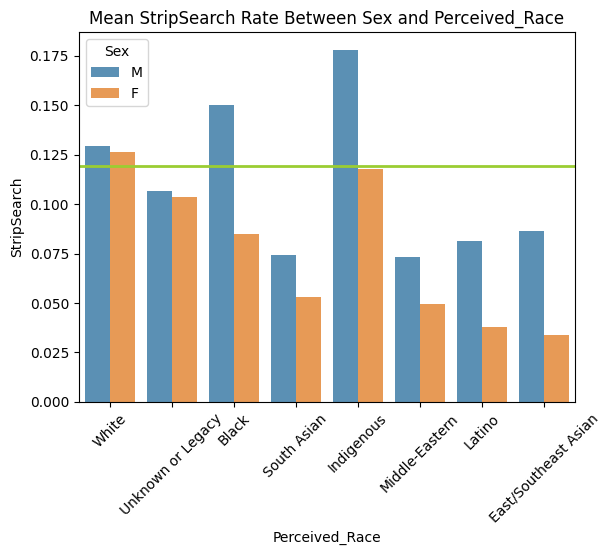

In [ ]:
plt.figure()

ax1=sns.barplot(data=ss, x='Perceived_Race', y='StripSearch', hue='Sex', alpha=0.8, errorbar=None)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45)

plt.axhline(ss['StripSearch'].mean(), linewidth=2, color='yellowgreen')
plt.title('Mean StripSearch Rate Between Sex and Perceived_Race')
plt.legend(loc='upper left', title='Sex')
plt.show()

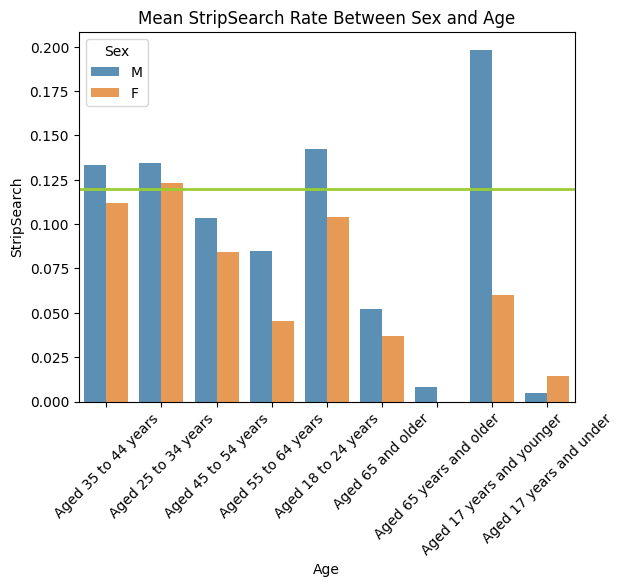

In [ ]:
plt.figure()

ax2=sns.barplot(data=ss, x='Age', y='StripSearch', hue='Sex', alpha=0.8, errorbar=None)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=45)

plt.axhline(ss['StripSearch'].mean(), linewidth=2, color='yellowgreen')
plt.title('Mean StripSearch Rate Between Sex and Age')
plt.legend(loc='upper left', title='Sex')
plt.show()

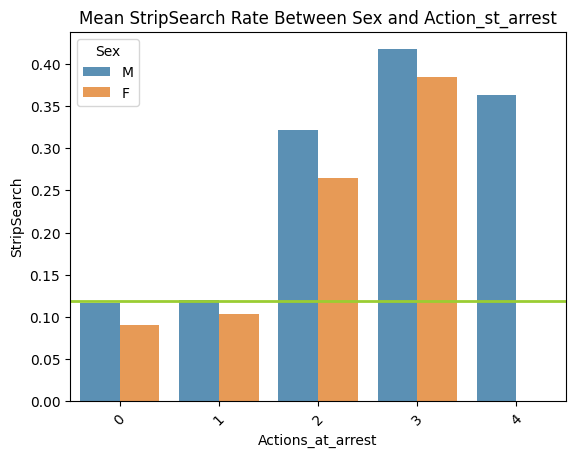

In [ ]:
plt.figure()

ax3=sns.barplot(data=ss, 
                x='Actions_at_arrest', y='StripSearch', hue='Sex', 
                alpha=0.8, errorbar=None)
ax3.set_xticklabels(ax3.get_xticklabels(),rotation=45)

plt.axhline(ss['StripSearch'].mean(), linewidth=2, color='yellowgreen')
plt.title('Mean StripSearch Rate Between Sex and Action_st_arrest')
plt.legend(loc='upper left', title='Sex')
plt.show()

### Pie Charts

In [ ]:
ss1 = ss.copy()

ss1['if_StripSearched'] = ss1['StripSearch'].map({1: 'StripSearched', 0: 'Not-StripSearched'})

fig = px.sunburst(
    data_frame=ss1,
    title='Sex',
    path=['Sex', 'if_StripSearched'],
    color_discrete_sequence=['#F3E8FF', '#BACDDB'],
    height=500,
    width=800,
)
fig.update_traces(textinfo='label+percent parent', insidetextorientation='horizontal')
fig.show()

## Ancova DF EDA

In [ ]:
ssif.head()

,Arrest_Year,Arrest_Month,Perceived_Race,Sex,StripSearch,ItemsFound
0,2020,Apr-June,Black,F,46,24.0
1,2020,Apr-June,Black,M,480,195.0
2,2020,Apr-June,East/Southeast Asian,F,6,1.0
3,2020,Apr-June,East/Southeast Asian,M,75,28.0
4,2020,Apr-June,Indigenous,F,13,7.0


### Box Plots

In [ ]:
import matplotlib.patheffects as path_effects

def add_median_labels(ax, fmt='.2f'):

  lines = ax.get_lines()
  boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
  lines_per_box = int(len(lines) / len(boxes))

  for median in lines[4:len(lines):lines_per_box]:
      x, y = (data.mean() for data in median.get_data())

      # choose value depending on horizontal or vertical plot orientation
      value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
      text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                      fontweight='bold', color='white',fontsize='small')
      
      # create median-colored border around white text for contrast
      text.set_path_effects([
          path_effects.Stroke(linewidth=3, foreground=median.get_color()),
          path_effects.Normal(),
      ])

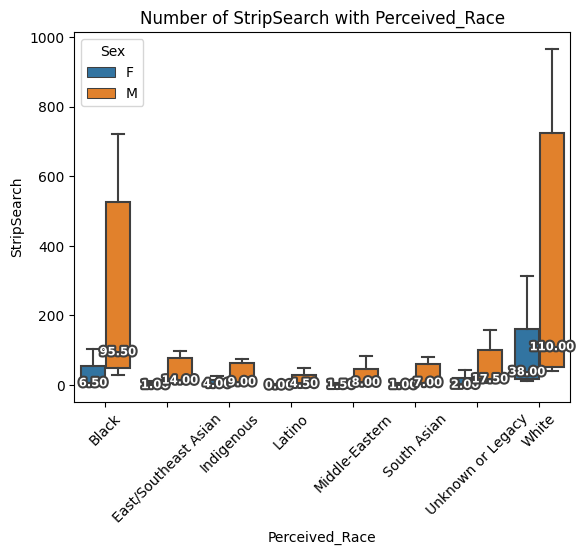

In [ ]:
plt.figure()

ax5 = sns.boxplot(data=ssif, x='Perceived_Race', y='StripSearch', hue='Sex', showfliers=False)  
ax5.set_xticklabels(ax5.get_xticklabels(),rotation=45)

add_median_labels(ax5)
ax5.set_title('Number of StripSearch with Perceived_Race')

plt.show()

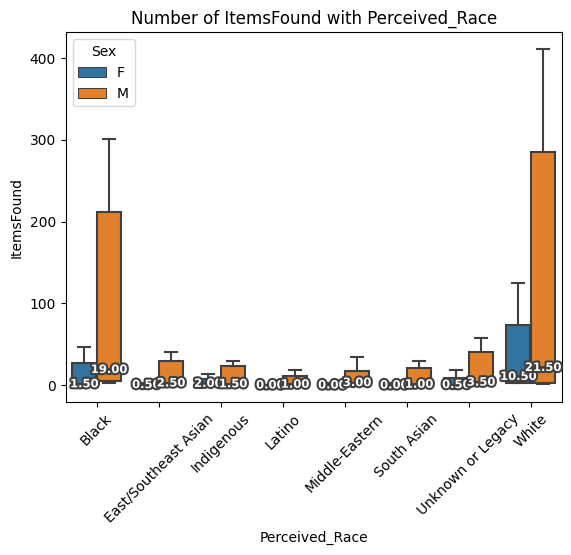

In [ ]:
plt.figure()
ax6 = sns.boxplot(data=ssif, x='Perceived_Race', y='ItemsFound',hue='Sex', showfliers=False)   
ax6.set_xticklabels(ax6.get_xticklabels(),rotation=45)

add_median_labels(ax6)
ax6.set_title('Number of ItemsFound with Perceived_Race')

plt.show()

### Line Chart

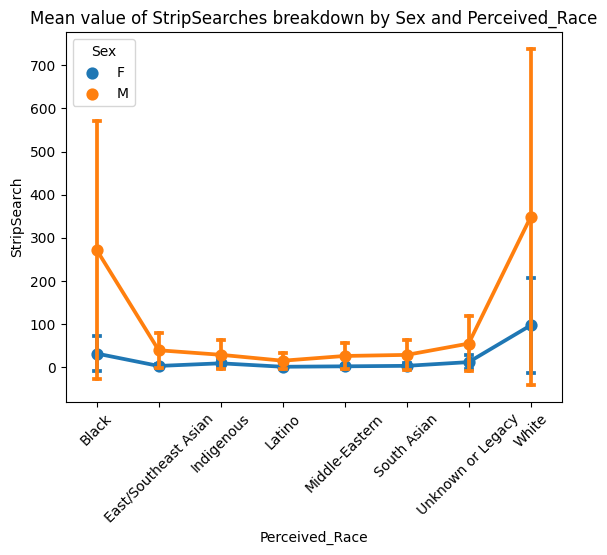

In [ ]:
plt.figure()
ax7=sns.pointplot(data=ssif, 
                  x='Perceived_Race', y='StripSearch',hue='Sex', 
                  capsize=.1, ci='sd')

ax7.set_xticklabels(ax7.get_xticklabels(),rotation=45)
ax7.set_title('Mean value of StripSearches breakdown by Sex and Perceived_Race')
plt.show()

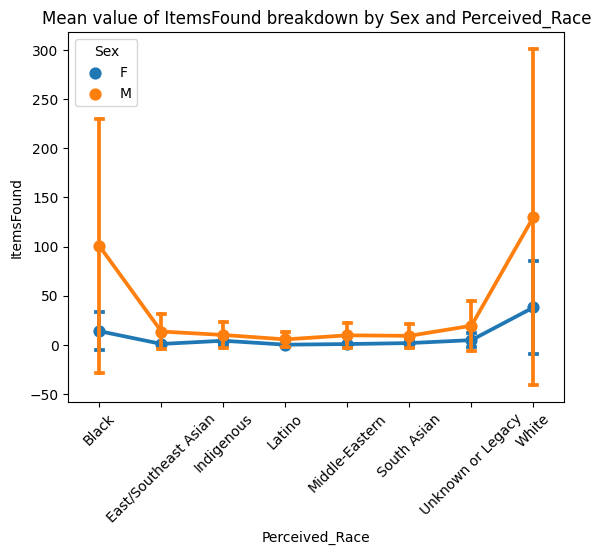

In [ ]:
plt.figure()
ax8=sns.pointplot(data=ssif, 
                  x='Perceived_Race', y='ItemsFound',hue='Sex', 
                  capsize=.1, ci='sd')

ax8.set_xticklabels(ax8.get_xticklabels(),rotation=45)
ax8.set_title('Mean value of ItemsFound breakdown by Sex and Perceived_Race')
plt.show()

# ANCOVA

## Power Analysis <br>
The following power analysis code referenced TA's Tutorial. Link is here: http://localhost:8888/notebooks/Desktop/INF2178/inf2178-expdesignfordatascience-w23/Lab/Power_analysis_example03_13.ipynb

In [ ]:
#code for Cohen's D 

#function to calculate the pooled standard deviation of 2 samples
def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)

# function to calculate Cohen's d for independent samples
def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)

### Sex

In [ ]:
#create male/female groups from dataset 
#creating two different datasets one with Sex=Male & Sex=Female

ssif_male = ssif[ssif['Sex']=='M']['ItemsFound']
ssif_female = ssif[ssif['Sex']=='F']['ItemsFound']

In [ ]:
#conduct power analysis 
from statsmodels.stats.power import TTestIndPower

effect_size = Cohens_d(ssif_male,ssif_female)
alpha = 0.05
power = 0.8
ratio_ = len(ssif_male)/len(ssif_female) #NB: ratio = nobs2/nobs1
print('Effect size (Cohen\'s D) for sex:',effect_size)

#https://www.statsmodels.org/dev/generated/statsmodels.stats.power.TTestIndPower.solve_power.html
analysis = TTestIndPower()

sample_size = analysis.solve_power(effect_size, power=power, ratio=ratio_, alpha=alpha)
print('Sample Size of itemsfound: %.3f' % sample_size, 'needed for male') 
print('Actual size of female:', len(ssif_female))

nobs2 = ratio_ * sample_size
print('Sample Size of itemsfound: %.3f' % nobs2, 'needed for female')
print('Actual size of male:', len(ssif_male))

Effect size (Cohen's D) for sex: 0.4658182086199752
Sample Size of itemsfound: 73.317 needed for male
Actual size of female: 64
Sample Size of itemsfound: 73.317 needed for female
Actual size of male: 64


/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning:

invalid value encountered in _nct_sf

/usr/local/lib/python3.9/dist-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning:

invalid value encountered in _nct_cdf



### Perceived_Race

In [ ]:
#Get the actual sample size for each race group
ssif['Perceived_Race'].value_counts()

Black                   16
East/Southeast Asian    16
Indigenous              16
Latino                  16
Middle-Eastern          16
South Asian             16
Unknown or Legacy       16
White                   16
Name: Perceived_Race, dtype: int64

In [ ]:
#Calculate the effect size
pg.power_anova(n=16, k=8, power=0.80, alpha=0.05)

0.1061836855317018

In [ ]:
#Calculate the Sample size
pg.power_anova(eta_squared=0.1, k=8, power=0.80)

17.043322490720534

## Ancova

In [ ]:
#Ancova analysis between ItemsFound and (Sex & Strip Searches)
pg.ancova(data=ssif, dv='ItemsFound', covar='StripSearch', between='Sex')

,Source,SS,DF,F,p-unc,np2
0,Sex,631.646501,1,19.352167,2.301684e-05,0.134062
1,StripSearch,490078.600071,1,15014.858759,4.504537e-132,0.991744
2,Residual,4079.946804,125,NaN,NaN,NaN


In [ ]:
#Ancova analysis between ItemsFound and (Perceived_Race & Strip Searches)
pg.ancova(data=ssif, dv='ItemsFound', covar='StripSearch', between='Perceived_Race')

,Source,SS,DF,F,p-unc,np2
0,Perceived_Race,876.620743,7,3.885961,7.586590e-04,0.186056
1,StripSearch,412826.839938,1,12810.103112,5.271731e-123,0.990796
2,Residual,3834.972562,119,NaN,NaN,NaN


# Logistic Regression

## Chi-Square Tests


In [ ]:
expected, observed, stats = pg.chi2_independence(ss, x='Sex', y='StripSearch')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,46.666778,1.0,8.414348e-12,0.026746,0.999999
1,cressie-read,0.666667,47.201657,1.0,6.404628e-12,0.026899,1.000000
2,log-likelihood,0.000000,48.318457,1.0,3.623258e-12,0.027215,1.000000
3,freeman-tukey,-0.500000,49.199202,1.0,2.312448e-12,0.027462,1.000000
4,mod-log-likelihood,-1.000000,50.118919,1.0,1.447051e-12,0.027718,1.000000
5,neyman,-2.000000,52.082980,1.0,5.320410e-13,0.028256,1.000000


In [ ]:
expected, observed, stats = pg.chi2_independence(ss, x='Perceived_Race', y='StripSearch')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,383.905230,7.0,6.731484e-79,0.076713,1.0
1,cressie-read,0.666667,393.557095,7.0,5.741896e-81,0.077672,1.0
2,log-likelihood,0.000000,415.961659,7.0,8.990462e-86,0.079852,1.0
3,freeman-tukey,-0.500000,435.866837,7.0,4.807727e-90,0.081740,1.0
4,mod-log-likelihood,-1.000000,458.869846,7.0,5.526993e-95,0.083870,1.0
5,neyman,-2.000000,516.162033,7.0,2.684502e-107,0.088951,1.0


In [ ]:
expected, observed, stats = pg.chi2_independence(ss, x='Age', y='StripSearch')
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,478.087546,8.0,3.526559e-98,0.085608,1.0
1,cressie-read,0.666667,519.658567,8.0,4.251214e-107,0.089252,1.0
2,log-likelihood,0.000000,655.155213,8.0,3.210908e-136,0.100215,1.0
3,freeman-tukey,-0.500000,850.391907,8.0,2.821159e-178,0.114175,1.0
4,mod-log-likelihood,-1.000000,1236.874393,8.0,1.032719e-261,0.137696,1.0
5,neyman,-2.000000,4172.591269,8.0,0.000000e+00,0.252908,1.0


In [ ]:
expected, observed, stats = pg.chi2_independence(ss, x='Actions_at_arrest', y='StripSearch')
stats

/usr/local/lib/python3.9/dist-packages/pingouin/contingency.py:150: UserWarning:

Low count on expected frequencies.



,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,710.377999,4.0,1.972686e-152,0.104353,1.0
1,cressie-read,0.666667,633.468227,4.0,8.834586e-136,0.098542,1.0
2,log-likelihood,0.000000,519.253268,4.0,4.587799e-111,0.089217,1.0
3,freeman-tukey,-0.500000,458.622640,4.0,5.938467e-98,0.083847,1.0
4,mod-log-likelihood,-1.000000,413.091916,4.0,4.124246e-88,0.079576,1.0
5,neyman,-2.000000,353.012759,4.0,3.921637e-75,0.073562,1.0


## Logistic Regression Model

### Load and Split the Data

Please note that the following part of the code referenced the code from INF2178 tutorial.

In [ ]:
y = pd.get_dummies(ss['StripSearch'], drop_first=True)

y = y.rename(columns={1: 'StripSearched'})
y.head()

,StripSearched
0,0
1,0
2,0
3,0
4,0


In [ ]:
#Select the feature that we'd like to analyze
x = ss[['Sex', 'Perceived_Race', 'Actions_at_arrest', 'Age']].copy()

In [ ]:
# Split these data into training and testing datasets
#set random seed for replicability 
#you may want to consider stratifying your train test split (creates splits by preserving the same percentage for each target class as in the complete set.)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=123)

### Run Regression

In [ ]:
#building the model with statsmodels
import statsmodels.formula.api as smf

# Create the formula string 
all_columns = ' + '.join(x)
formula = "StripSearched ~ " + all_columns 
print("Formula: ", formula, "\n")

# Put the training predictors and responses into one DataFrame to be input into the model
trainingdata = pd.concat([x_train,y_train], axis = 1)

# Build the model
log_reg_1 = smf.logit(formula, data=trainingdata).fit()

Formula:  StripSearched ~ Sex + Perceived_Race + Actions_at_arrest + Age 

Optimization terminated successfully.
         Current function value: 0.354622
         Iterations 9


In [ ]:
log_reg_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          StripSearched   No. Observations:                52188
Model:                          Logit   Df Residuals:                    52170
Method:                           MLE   Df Model:                           17
Date:                Sun, 09 Apr 2023   Pseudo R-squ.:                 0.02892
Time:                        03:28:49   Log-Likelihood:                -18507.
converged:                       True   LL-Null:                       -19058.
Covariance Type:            nonrobust   LLR p-value:                1.193e-223
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -5.1861      0.357    -14.529      0.000      -5.886      -4.486
Sex[T.M]                                   0.2676      0.037      7.330      0.000       0.196       0.339
Perceived_Race[T.East/Southeast Asian]    -0.5921      0.067     -8.816      0.000      -0.724      -0.460
Perceived_Race[T.Indigenous]               0.1949      0.075      2.596      0.009       0.048       0.342
Perceived_Race[T.Latino]                  -0.7779      0.107     -7.239      0.000      -0.988      -0.567
Perceived_Race[T.Middle-Eastern]          -0.7596      0.081     -9.375      0.000      -0.918      -0.601
Perceived_Race[T.South Asian]             -0.7871      0.078    -10.038      0.000      -0.941      -0.633
Perceived_Race[T.Unknown or Legacy]       -0.3010      0.058     -5.200      0.000      -0.414      -0.188
Perceived_Race[T.White]                   -0.0121      0.033     -0.371      0.711      -0.076       0.052
Age[T.Aged 17 years and younger]           3.2972      0.363      9.088      0.000       2.586       4.008
Age[T.Aged 18 to 24 years]                 3.1024      0.357      8.702      0.000       2.404       3.801
Age[T.Aged 25 to 34 years]                 3.0378      0.356      8.539      0.000       2.340       3.735
Age[T.Aged 35 to 44 years]                 2.9793      0.356      8.367      0.000       2.281       3.677
Age[T.Aged 45 to 54 years]                 2.6907      0.357      7.530      0.000       1.990       3.391
Age[T.Aged 55 to 64 years]                 2.4740      0.360      6.866      0.000       1.768       3.180
Age[T.Aged 65 and older]                   2.0723      0.407      5.093      0.000       1.275       2.870
Age[T.Aged 65 years and older]            -0.2676      0.679     -0.394      0.694      -1.599       1.064
Actions_at_arrest                          0.3172      0.023     13.651      0.000       0.272       0.363
==========================================================================================================
"""

In [ ]:
#getting odds ratio 
a=np.exp(log_reg_1.params)
my_table = a.to_frame()
my_table

,0
Intercept,0.005594
Sex[T.M],1.306851
Perceived_Race[T.East/Southeast Asian],0.553153
Perceived_Race[T.Indigenous],1.215244
Perceived_Race[T.Latino],0.459386
Perceived_Race[T.Middle-Eastern],0.467845
Perceived_Race[T.South Asian],0.455141
Perceived_Race[T.Unknown or Legacy],0.740112
Perceived_Race[T.White],0.987965
Age[T.Aged 17 years and younger],27.036036


In [ ]:
params = log_reg_1.params
conf = log_reg_1.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Intercept,0.002779,0.011260,0.005594
Sex[T.M],1.216603,1.403795,1.306851
Perceived_Race[T.East/Southeast Asian],0.484928,0.630976,0.553153
Perceived_Race[T.Indigenous],1.048938,1.407916,1.215244
Perceived_Race[T.Latino],0.372145,0.567077,0.459386
Perceived_Race[T.Middle-Eastern],0.399147,0.548366,0.467845
Perceived_Race[T.South Asian],0.390302,0.530751,0.455141
Perceived_Race[T.Unknown or Legacy],0.660740,0.829018,0.740112
Perceived_Race[T.White],0.926769,1.053201,0.987965
Age[T.Aged 17 years and younger],13.277993,55.049526,27.036036


### Assess the Model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
# Predict responses 
pred_1 = log_reg_1.predict(x_test)
# round() rounds to nearest integer;
# 0.5 rounds to 0; 0.501 rounds to 1
prediction_1 = list(map(round, pred_1))

In [ ]:
# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction_1))


Test accuracy =  0.8788227178661762



Confusion Matrix : 
 [[11466     0]
 [ 1581     0]]


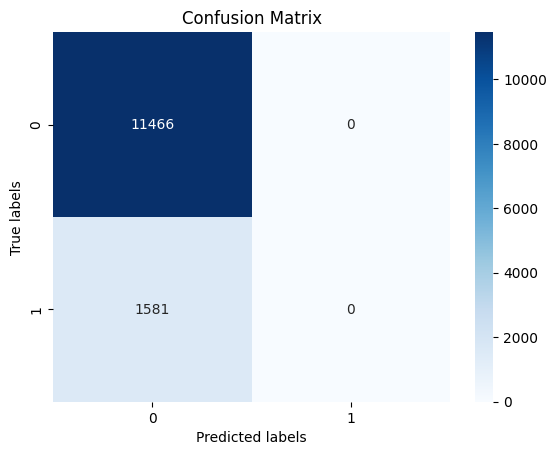

In [ ]:
# Confusion matrix
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
#C0,0 is true negative, C1,0 is false negative, C1,1 is true positive, C0,1 false positive 

cm = confusion_matrix(y_test, prediction_1) 
print ("\nConfusion Matrix : \n", cm) 

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

# Set the axis labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()